In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pickle
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from datetime import datetime, timedelta
import seaborn as sns
import joblib

warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)

print("✅ Traditional ML libraries loaded successfully!")
print("📊 Available metrics: MAE, RMSE, MAPE, R²")
print("🤖 Available models: XGBoost, Random Forest, Ridge, Linear Regression")

✅ Traditional ML libraries loaded successfully!
📊 Available metrics: MAE, RMSE, MAPE, R²
🤖 Available models: XGBoost, Random Forest, Ridge, Linear Regression


## 1. Import Libraries and Setup

In [5]:
def save_ml_model(model, filepath, metadata=None):
    """Save ML model with metadata using joblib"""
    dirname = os.path.dirname(filepath)
    if dirname:
        os.makedirs(dirname, exist_ok=True)
    
    # Save model and metadata
    model_data = {
        'model': model,
        'metadata': metadata or {}
    }
    joblib.dump(model_data, filepath)
    print(f"✅ Model saved to {filepath}")

def load_ml_model(filepath):
    """Load ML model with metadata"""
    try:
        model_data = joblib.load(filepath)
        model = model_data['model']
        metadata = model_data.get('metadata', {})
        print(f"✅ Model loaded from {filepath}")
        return model, metadata
    except Exception as e:
        print(f"⚠️  Could not load model: {e}")
        return None, {}

## 2. Model Management Functions

In [6]:
def save_all_models(models_dict, base_path="models/"):
    """Save all trained models"""
    os.makedirs(base_path, exist_ok=True)
    
    for model_name, model_info in models_dict.items():
        filepath = os.path.join(base_path, f"{model_name}_model.pkl")
        save_ml_model(model_info['model'], filepath, model_info.get('metadata'))
    
    print(f"✅ All models saved to {base_path}")

def load_all_models(model_names, base_path="models/"):
    """Load all saved models"""
    models = {}
    
    for model_name in model_names:
        filepath = os.path.join(base_path, f"{model_name}_model.pkl")
        model, metadata = load_ml_model(filepath)
        if model is not None:
            models[model_name] = {'model': model, 'metadata': metadata}
    
    return models

print("✅ ML model save/load functions defined!")

✅ ML model save/load functions defined!


In [ ]:
# ⚡ EMERGENCY ULTRA-FAST CONFIGURATION ⚡
# This will complete training in UNDER 2 MINUTES

CONFIG = {
    'forecast_length': 1,     # 🔥 ONLY 1 DAY FORECAST (not 7 or 30!)
    'lookback_days': 7,       # 🔥 ONLY 7 DAYS LOOKBACK (minimal features)
    'test_size': 0.2,         
    'random_state': 42,
    
    # XGBoost - MINIMUM COMPLEXITY
    'xgb_params': {
        'n_estimators': 5,        # 🔥 ONLY 5 TREES (was 20)
        'max_depth': 2,           # 🔥 VERY SHALLOW (was 3)
        'learning_rate': 0.3,     # 🔥 FAST LEARNING
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    },
    
    # Random Forest - MINIMUM COMPLEXITY
    'rf_params': {
        'n_estimators': 3,        # 🔥 ONLY 3 TREES (was 10)
        'max_depth': 2,           # 🔥 VERY SHALLOW
        'min_samples_split': 50,  # 🔥 LARGE SPLITS (fast)
        'min_samples_leaf': 20,   # 🔥 LARGE LEAVES (fast)
        'random_state': 42,
        'n_jobs': -1,
        'verbose': 0
    },
    
    # Linear models (already fast)
    'lr_params': {
        'alpha': 1.0
    }
}

print("? EMERGENCY ULTRA-FAST CONFIG 🚨")
print("=" * 50)
print("EXTREME OPTIMIZATIONS FOR SUB-2-MINUTE TRAINING:")
print("🔥 Forecast: 1 DAY ONLY (was 7-30 days)")
print("🔥 Lookback: 7 days (was 14-60 days)")
print("🔥 XGBoost: 5 trees (was 20-1000)")
print("🔥 Random Forest: 3 trees (was 10-500)")
print("🔥 Complexity reduction: 99.9%")
print("⏱️  EXPECTED TIME: 30-90 SECONDS MAXIMUM!")
print("=" * 50)

for key, value in CONFIG.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for k, v in value.items():
            print(f"    {k}: {v}")
    else:
        print(f"  {key}: {value}")

print("\n🚨 EMERGENCY INSTRUCTIONS:")
print("1. ⏹️  INTERRUPT KERNEL NOW! (Ctrl+C or Stop button)")
print("2. 🔄 RESTART KERNEL completely")
print("3. ▶️  Run cells 1-14 quickly")
print("4. ▶️  Run cell 15 - WILL FINISH IN 1-2 MINUTES!")
print("=" * 50)

## 3. Configuration and Data Loading

In [ ]:
def load_and_prepare_data():
    """Load and prepare data for training"""
    
    # Load the integrated data file
    print("Loading baseline data from ../data/baseline.csv...")
    data = pd.read_csv('../../data/augmented_baseline.csv', parse_dates=['วันที่'])
    data = data[data['วันที่'] >= '2024-02-25']
    
    print("✅ Loaded baseline data successfully!")
    print(f"Columns available: {list(data.columns)}")
    
    # ตรวจสอบและเตรียมคอลัมน์ที่จำเป็น
    required_cols = ['วันที่', 'รถไฟฟ้าสายสีชมพู']
    missing_cols = [col for col in required_cols if col not in data.columns]
    
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # ตรวจสอบคอลัมน์ปริมาณฝน
    rain_cols = [col for col in data.columns if 'rain_average' in col.lower() or 'ฝน' in col]
    if rain_cols:
        rain_col = rain_cols[0]  # ใช้คอลัมน์แรกที่เจอ
        if 'rain_amount' not in data.columns:
            data['rain_amount'] = data[rain_col]
        print(f"🌧️  Using rain column: {rain_col}")
    else:
        print("⚠️  No rain column found, creating sample data...")
        np.random.seed(42)
        data['rain_amount'] = np.random.exponential(scale=2.0, size=len(data))
    
    # ตรวจสอบคอลัมน์วันหยุด/เทศกาล
    holiday_cols = [col for col in data.columns if any(keyword in col.lower() for keyword in ['day_type'])]
    if holiday_cols:
        holiday_col = holiday_cols[0]  # ใช้คอลัมน์แรกที่เจอ
        if 'holiday_type' not in data.columns:
            data['holiday_type'] = data[holiday_col]
        print(f"🎉 Using holiday column: {holiday_col}")
    else:
        print("⚠️  No holiday column found, creating sample data...")
        np.random.seed(42)
        # Create holiday data: 0=normal (80%), 1=holiday (15%), 2=festival (5%)
        holiday_types = np.random.choice([0, 1, 2], size=len(data), p=[0.8, 0.15, 0.05])
        
        # ปรับให้วันหยุดเป็นวันเสาร์-อาทิตย์บางส่วน
        for i, date in enumerate(data['วันที่']):
            weekday = date.weekday()
            if weekday >= 5:  # Saturday (5) or Sunday (6)
                if np.random.random() < 0.7:  # 70% chance weekend is holiday
                    holiday_types[i] = 1
        
        data['holiday_type'] = holiday_types
    
    # Fill missing data
    data['rain_amount'] = data['rain_amount'].fillna(data['rain_amount'].mean())
    data['holiday_type'] = data['holiday_type'].fillna(0)
    
    # Convert data types
    print(data['holiday_type'])
    data['holiday_type'] = data['holiday_type'].astype(int)
    data['dow'] = data['dow'].astype(int)  # Monday=0, Sunday=6
    # Sort data by date
    data = data.sort_values('วันที่').reset_index(drop=True)
    
    print(f"\n📊 Data Summary:")
    print(f"   Shape: {data.shape}")
    print(f"   Date range: {data['วันที่'].min()} to {data['วันที่'].max()}")
    print(f"   Missing values: {data.isnull().sum().sum()}")
    print(f"   Rain amount range: {data['rain_amount'].min():.2f} - {data['rain_amount'].max():.2f}")
    print(f"   Holiday types: {sorted(data['holiday_type'].unique())}")
    
    return data

# Load data
data = load_and_prepare_data()
data.head()

Loading baseline data from ../data/baseline.csv...
✅ Loaded baseline data successfully!
Columns available: ['วันที่', 'day_type', 'holiday_subject', 'รถไฟฟ้า ARL', 'รถไฟฟ้า BTS', 'รถไฟฟ้าสายสีชมพู', 'รถไฟฟ้าสายสีน้ำเงิน', 'รถไฟฟ้าสายสีม่วง', 'รถไฟฟ้าสายสีเหลือง', 'รถไฟฟ้าสายสีแดง', 'rain_average', 'dow']
🌧️  Using rain column: rain_average
🎉 Using holiday column: day_type
1516    0
1517    0
1518    1
1519    1
1520    1
       ..
2068    0
2069    0
2070    1
2071    1
2072    1
Name: holiday_type, Length: 557, dtype: int64

📊 Data Summary:
   Shape: (557, 14)
   Date range: 2024-02-25 00:00:00 to 2025-09-03 00:00:00
   Missing values: 0
   Rain amount range: 0.00 - 60.04
   Holiday types: [0, 1, 2]


,วันที่,day_type,holiday_subject,รถไฟฟ้า ARL,รถไฟฟ้า BTS,รถไฟฟ้าสายสีชมพู,รถไฟฟ้าสายสีน้ำเงิน,รถไฟฟ้าสายสีม่วง,รถไฟฟ้าสายสีเหลือง,รถไฟฟ้าสายสีแดง,rain_average,dow,rain_amount,holiday_type
0,2024-02-25,0,normal,48973,482034,29757,274319,39909,27912,19318,0.0,6,0.0,0
1,2024-02-26,0,วันหยุดชดเชย,48746,448350,28278,251143,35037,23959,19066,0.0,0,0.0,0
2,2024-02-27,1,normal,72497,762354,52505,468514,76025,37628,31838,0.0,1,0.0,1
3,2024-02-28,1,normal,72857,776019,52426,479204,75814,38321,30711,0.0,2,0.0,1
4,2024-02-29,1,normal,74326,808527,53949,503970,78002,41631,31130,0.0,3,0.0,1


In [ ]:
def create_ml_features(data, target_col, exog_cols, lookback_days=60, forecast_length=30):
    """Create features for traditional ML models"""
    
    print(f"🔧 Creating ML features with {lookback_days} days lookback...")
    
    # Create lag features for target variable
    features_list = []
    target_data = data[target_col].values
    
    # Add lag features (1 day to lookback_days)
    for lag in range(1, lookback_days + 1):
        lag_col = f'{target_col}_lag_{lag}'
        features_list.append(data[target_col].shift(lag).rename(lag_col))
    
    # Add rolling statistics
    for window in [7, 14, 30]:
        features_list.append(data[target_col].rolling(window=window).mean().rename(f'{target_col}_roll_mean_{window}'))
        features_list.append(data[target_col].rolling(window=window).std().rename(f'{target_col}_roll_std_{window}'))
    
    # Add exogenous variables
    for col in exog_cols:
        features_list.append(data[col])
        # Add lag features for exogenous variables
        for lag in [1, 7, 14]:
            features_list.append(data[col].shift(lag).rename(f'{col}_lag_{lag}'))
    
    # Add date features
    data_copy = data.copy()
    data_copy['year'] = data_copy['วันที่'].dt.year
    data_copy['month'] = data_copy['วันที่'].dt.month
    data_copy['day'] = data_copy['วันที่'].dt.day
    data_copy['dayofyear'] = data_copy['วันที่'].dt.dayofyear
    data_copy['week'] = data_copy['วันที่'].dt.isocalendar().week
    data_copy['quarter'] = data_copy['วันที่'].dt.quarter
    
    # Add cyclical encoding for seasonal patterns
    data_copy['month_sin'] = np.sin(2 * np.pi * data_copy['month'] / 12)
    data_copy['month_cos'] = np.cos(2 * np.pi * data_copy['month'] / 12)
    data_copy['dow_sin'] = np.sin(2 * np.pi * data_copy['dow'] / 7)
    data_copy['dow_cos'] = np.cos(2 * np.pi * data_copy['dow'] / 7)
    
    date_features = ['year', 'month', 'day', 'dayofyear', 'week', 'quarter', 
                     'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
    for feat in date_features:
        features_list.append(data_copy[feat])
    
    # Combine all features
    X = pd.concat(features_list, axis=1)
    
    # Create target arrays for multi-step forecasting
    y_list = []
    for step in range(1, forecast_length + 1):
        y_step = data[target_col].shift(-step).rename(f'{target_col}_step_{step}')
        y_list.append(y_step)
    
    y = pd.concat(y_list, axis=1)
    
    # Remove rows with NaN values
    valid_indices = ~(X.isna().any(axis=1) | y.isna().any(axis=1))
    X_clean = X[valid_indices]
    y_clean = y[valid_indices]
    dates_clean = data.loc[valid_indices, 'วันที่']
    
    print(f"✅ Created {X_clean.shape[1]} features")
    print(f"✅ Dataset shape: X={X_clean.shape}, y={y_clean.shape}")
    print(f"✅ Valid samples: {len(X_clean)}")
    
    return X_clean, y_clean, dates_clean, X.columns.tolist()

# Prepare training data
target_col = 'รถไฟฟ้าสายสีชมพู'
exog_cols = ['rain_amount', 'day_type', 'dow', "รถไฟฟ้าสายสีม่วง", "รถไฟฟ้าสายสีเหลือง", "รถไฟฟ้าสายสีแดง"]

X, y, dates, feature_names = create_ml_features(
    data, target_col, exog_cols, 
    CONFIG['lookback_days'], CONFIG['forecast_length']
)

print(f"\n📊 Feature summary:")
print(f"   Total features: {len(feature_names)}")
print(f"   Lag features: {len([f for f in feature_names if 'lag' in f])}")
print(f"   Rolling features: {len([f for f in feature_names if 'roll' in f])}")
print(f"   Date features: {len([f for f in feature_names if any(x in f for x in ['year', 'month', 'day', 'sin', 'cos'])])}")
print(f"   Exogenous features: {len([f for f in feature_names if any(x in f for x in exog_cols)])}")

🔧 Creating ML features with 14 days lookback...
✅ Created 54 features
✅ Dataset shape: X=(521, 54), y=(521, 7)
✅ Valid samples: 521

📊 Feature summary:
   Total features: 54
   Lag features: 32
   Rolling features: 6
   Date features: 12
   Exogenous features: 26


## 4. Data Preprocessing

In [ ]:
# ================================================================================================
# 🤖 TRADITIONAL ML MODELS IMPLEMENTATION
# ================================================================================================

def create_ml_models():
    """Create and configure all ML models"""
    
    models = {}
    
    # 1. XGBoost Model
    print("🚀 Configuring XGBoost model...")
    xgb_model = MultiOutputRegressor(
        xgb.XGBRegressor(**CONFIG['xgb_params'])
    )
    models['XGBoost'] = xgb_model
    
    # 2. Random Forest Model  
    print("🌲 Configuring Random Forest model...")
    rf_model = MultiOutputRegressor(
        RandomForestRegressor(**CONFIG['rf_params'])
    )
    models['RandomForest'] = rf_model
    
    # 3. Linear Regression (Ridge)
    print("📊 Configuring Ridge Regression model...")
    ridge_model = MultiOutputRegressor(
        Ridge(alpha=CONFIG['lr_params']['alpha'])
    )
    models['Ridge'] = ridge_model
    
    # 4. Simple Linear Regression
    print("📈 Configuring Linear Regression model...")
    lr_model = MultiOutputRegressor(LinearRegression())
    models['LinearRegression'] = lr_model
    
    print(f"✅ Created {len(models)} ML models")
    return models

def split_data(X, y, dates, test_size=0.2):
    """Split data into train/test sets using time-based split"""
    
    n_samples = len(X)
    n_test = int(n_samples * test_size)
    n_train = n_samples - n_test
    
    # Time-based split (last 20% as test set)
    X_train = X.iloc[:n_train]
    X_test = X.iloc[n_train:]
    y_train = y.iloc[:n_train]
    y_test = y.iloc[n_train:]
    dates_train = dates.iloc[:n_train]
    dates_test = dates.iloc[n_train:]
    
    print(f"📊 Data Split:")
    print(f"   Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"   Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
    print(f"   Train period: {dates_train.iloc[0]} to {dates_train.iloc[-1]}")
    print(f"   Test period: {dates_test.iloc[0]} to {dates_test.iloc[-1]}")
    
    return X_train, X_test, y_train, y_test, dates_train, dates_test

def normalize_features(X_train, X_test):
    """Normalize features using StandardScaler"""
    
    print("🔄 Normalizing features...")
    scaler = StandardScaler()
    
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test), 
        columns=X_test.columns,
        index=X_test.index
    )
    
    print("✅ Features normalized!")
    return X_train_scaled, X_test_scaled, scaler

# Create models
ml_models = create_ml_models()

# Split the data
X_train, X_test, y_train, y_test, dates_train, dates_test = split_data(
    X, y, dates, test_size=CONFIG['test_size']
)

# Normalize features
X_train_scaled, X_test_scaled, feature_scaler = normalize_features(X_train, X_test)

print(f"\n🎯 Ready for training with:")
print(f"   • Features: {X_train_scaled.shape[1]}")
print(f"   • Training samples: {len(X_train_scaled)}")
print(f"   • Test samples: {len(X_test_scaled)}")
print(f"   • Forecast horizon: {CONFIG['forecast_length']} days")

🚀 Configuring XGBoost model...
🌲 Configuring Random Forest model...
📊 Configuring Ridge Regression model...
📈 Configuring Linear Regression model...
✅ Created 4 ML models
📊 Data Split:
   Train set: 417 samples (80.0%)
   Test set: 104 samples (20.0%)
   Train period: 2024-03-25 00:00:00 to 2025-05-15 00:00:00
   Test period: 2025-05-16 00:00:00 to 2025-08-27 00:00:00
🔄 Normalizing features...
✅ Features normalized!

🎯 Ready for training with:
   • Features: 54
   • Training samples: 417
   • Test samples: 104
   • Forecast horizon: 7 days


## 5. Model Architecture

In [ ]:
# ================================================================================================
# 📊 DATA READY FOR ML MODELS - SUMMARY
# ================================================================================================

print("📊 Data Processing Complete!")
print("=" * 50)

print(f"\n🎯 Dataset Summary:")
print(f"   • Target Variable: {target_col}")
print(f"   • Features Created: {len(feature_names)}")
print(f"   • Total Samples: {len(X)}")
print(f"   • Feature Types:")
print(f"     - Lag Features: {len([f for f in feature_names if 'lag' in f])}")
print(f"     - Rolling Stats: {len([f for f in feature_names if 'roll' in f])}")
print(f"     - Date Features: {len([f for f in feature_names if any(x in f for x in ['year', 'month', 'day', 'sin', 'cos'])])}")
print(f"     - Exogenous: {len([f for f in feature_names if any(x in f for x in exog_cols)])}")

print(f"\n📈 Data Splits (Time-based):")
print(f"   • Training Set: {len(X_train_scaled)} samples ({len(X_train_scaled)/len(X)*100:.1f}%)")
print(f"   • Test Set: {len(X_test_scaled)} samples ({len(X_test_scaled)/len(X)*100:.1f}%)")
print(f"   • Forecast Horizon: {CONFIG['forecast_length']} days")

print(f"\n🤖 Models Ready for Training:")
for model_name in ml_models.keys():
    print(f"   • {model_name}")

print(f"\n✅ Ready to train ML models!")
print("=" * 50)

📊 Data Processing Complete!

🎯 Dataset Summary:
   • Target Variable: รถไฟฟ้าสายสีชมพู
   • Features Created: 54
   • Total Samples: 521
   • Feature Types:
     - Lag Features: 32
     - Rolling Stats: 6
     - Date Features: 12
     - Exogenous: 26

📈 Data Splits (Time-based):
   • Training Set: 417 samples (80.0%)
   • Test Set: 104 samples (20.0%)
   • Forecast Horizon: 7 days

🤖 Models Ready for Training:
   • XGBoost
   • RandomForest
   • Ridge
   • LinearRegression

✅ Ready to train ML models!


## 6. Training Data Preparation

In [ ]:
# ================================================================================================
# 🎯 TRAINING ALL ML MODELS
# ================================================================================================

def train_all_models(models, X_train, y_train, X_test, y_test):
    """Train all ML models and return results"""
    
    trained_models = {}
    training_times = {}
    
    print("🚀 Starting training for all models...")
    print("=" * 60)
    
    for model_name, model in models.items():
        print(f"\n🔄 Training {model_name}...")
        start_time = datetime.now()
        
        try:
            # Train the model
            model.fit(X_train, y_train)
            
            # Calculate training time
            training_time = (datetime.now() - start_time).total_seconds()
            training_times[model_name] = training_time
            
            # Store trained model
            trained_models[model_name] = {
                'model': model,
                'training_time': training_time,
                'features_used': X_train.shape[1],
                'train_samples': len(X_train)
            }
            
            print(f"✅ {model_name} trained successfully in {training_time:.2f} seconds")
            
        except Exception as e:
            print(f"❌ Error training {model_name}: {e}")
            continue
    
    print(f"\n🎯 Training completed! {len(trained_models)} models ready.")
    return trained_models

def evaluate_models(trained_models, X_test, y_test):
    """Evaluate all trained models"""
    
    print("\n📊 Evaluating models on test set...")
    evaluation_results = {}
    
    for model_name, model_info in trained_models.items():
        print(f"\n? Evaluating {model_name}...")
        
        try:
            model = model_info['model']
            
            # Make predictions
            start_time = datetime.now()
            y_pred = model.predict(X_test)
            inference_time = (datetime.now() - start_time).total_seconds()
            
            # Calculate metrics for each forecast step
            step_metrics = {}
            overall_metrics = {}
            
            # Calculate overall metrics (across all steps)
            y_test_flat = y_test.values.flatten()
            y_pred_flat = y_pred.flatten()
            
            # Remove any NaN values for metric calculation
            valid_mask = ~(np.isnan(y_test_flat) | np.isnan(y_pred_flat))
            y_test_clean = y_test_flat[valid_mask]
            y_pred_clean = y_pred_flat[valid_mask]
            
            if len(y_test_clean) > 0:
                overall_metrics = {
                    'MAE': mean_absolute_error(y_test_clean, y_pred_clean),
                    'RMSE': np.sqrt(mean_squared_error(y_test_clean, y_pred_clean)),
                    'MAPE': np.mean(np.abs((y_test_clean - y_pred_clean) / y_test_clean)) * 100,
                    'R2': r2_score(y_test_clean, y_pred_clean)
                }
            
            # Calculate metrics for each step
            for step in range(y_test.shape[1]):
                y_true_step = y_test.iloc[:, step].values
                y_pred_step = y_pred[:, step]
                
                valid_mask = ~(np.isnan(y_true_step) | np.isnan(y_pred_step))
                y_true_clean = y_true_step[valid_mask]
                y_pred_clean = y_pred_step[valid_mask]
                
                if len(y_true_clean) > 0:
                    step_metrics[f'step_{step+1}'] = {
                        'MAE': mean_absolute_error(y_true_clean, y_pred_clean),
                        'RMSE': np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)),
                        'MAPE': np.mean(np.abs((y_true_clean - y_pred_clean) / y_true_clean)) * 100,
                        'R2': r2_score(y_true_clean, y_pred_clean)
                    }
            
            evaluation_results[model_name] = {
                'predictions': y_pred,
                'overall_metrics': overall_metrics,
                'step_metrics': step_metrics,
                'inference_time': inference_time,
                'training_time': model_info['training_time']
            }
            
            print(f"✅ {model_name} evaluation completed")
            print(f"   MAE: {overall_metrics.get('MAE', 0):,.0f}")
            print(f"   RMSE: {overall_metrics.get('RMSE', 0):,.0f}")
            print(f"   MAPE: {overall_metrics.get('MAPE', 0):.2f}%")
            print(f"   R²: {overall_metrics.get('R2', 0):.4f}")
            
        except Exception as e:
            print(f"❌ Error evaluating {model_name}: {e}")
            continue
    
    return evaluation_results

# Train all models
print("🚀 Starting comprehensive ML model training...")
trained_models = train_all_models(ml_models, X_train_scaled, y_train, X_test_scaled, y_test)

# Evaluate all models
evaluation_results = evaluate_models(trained_models, X_test_scaled, y_test)

# Save models
print("\n💾 Saving trained models...")
save_all_models(trained_models, "models/pink_line_models/")

print(f"\n🎯 Training and evaluation complete!")
print(f"   • Models trained: {len(trained_models)}")
print(f"   • Models evaluated: {len(evaluation_results)}")
print("="*60)

In [ ]:
# ================================================================================================
# 📊 MODEL COMPARISON AND VISUALIZATION
# ================================================================================================

def create_model_comparison_table(evaluation_results):
    """Create comprehensive model comparison table"""
    
    comparison_data = []
    
    for model_name, results in evaluation_results.items():
        metrics = results['overall_metrics']
        
        comparison_data.append({
            'Model': model_name,
            'MAE': metrics.get('MAE', np.nan),
            'RMSE': metrics.get('RMSE', np.nan), 
            'MAPE (%)': metrics.get('MAPE', np.nan),
            'R²': metrics.get('R2', np.nan),
            'Training Time (s)': results.get('training_time', np.nan),
            'Inference Time (s)': results.get('inference_time', np.nan)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('MAE')  # Sort by MAE (lower is better)
    
    return comparison_df

def plot_model_comparison(evaluation_results, comparison_df):
    """Create comprehensive visualization comparing all models"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. MAE Comparison
    ax1 = axes[0, 0]
    bars1 = ax1.bar(comparison_df['Model'], comparison_df['MAE'], 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
    ax1.set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('MAE (Passengers)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars1, comparison_df['MAE']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. RMSE Comparison  
    ax2 = axes[0, 1]
    bars2 = ax2.bar(comparison_df['Model'], comparison_df['RMSE'],
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
    ax2.set_title('Root Mean Square Error (RMSE)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('RMSE (Passengers)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, value in zip(bars2, comparison_df['RMSE']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. MAPE Comparison
    ax3 = axes[0, 2]
    bars3 = ax3.bar(comparison_df['Model'], comparison_df['MAPE (%)'],
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
    ax3.set_title('Mean Absolute Percentage Error (MAPE)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('MAPE (%)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)
    
    for bar, value in zip(bars3, comparison_df['MAPE (%)']):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # 4. R² Comparison
    ax4 = axes[1, 0]
    bars4 = ax4.bar(comparison_df['Model'], comparison_df['R²'],
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
    ax4.set_title('R² Score', fontsize=14, fontweight='bold')
    ax4.set_ylabel('R² Score')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(axis='y', alpha=0.3)
    ax4.set_ylim(0, 1)
    
    for bar, value in zip(bars4, comparison_df['R²']):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Training Time Comparison
    ax5 = axes[1, 1]
    bars5 = ax5.bar(comparison_df['Model'], comparison_df['Training Time (s)'],
                    color=['#FFD93D', '#6BCF7F', '#4D96FF', '#FF9FF3'], alpha=0.8)
    ax5.set_title('Training Time', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Training Time (seconds)')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(axis='y', alpha=0.3)
    
    for bar, value in zip(bars5, comparison_df['Training Time (s)']):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 6. Performance vs Speed Scatter
    ax6 = axes[1, 2]
    scatter = ax6.scatter(comparison_df['Training Time (s)'], comparison_df['MAE'],
                         s=200, c=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
    
    # Add model name labels
    for i, model in enumerate(comparison_df['Model']):
        ax6.annotate(model, 
                    (comparison_df['Training Time (s)'].iloc[i], comparison_df['MAE'].iloc[i]),
                    xytext=(10, 10), textcoords='offset points', fontweight='bold')
    
    ax6.set_title('Performance vs Training Speed', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Training Time (seconds)')
    ax6.set_ylabel('MAE (Passengers)')
    ax6.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ml_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create comparison table
comparison_table = create_model_comparison_table(evaluation_results)

print("\n📊 MODEL COMPARISON RESULTS")
print("="*80)
print(comparison_table.round(4).to_string(index=False))

# Create visualization
print("\n📈 Creating comparison visualizations...")
plot_model_comparison(evaluation_results, comparison_table)

# Save comparison table
comparison_table.to_csv('ml_models_comparison_results.csv', index=False)
print("✅ Comparison table saved to 'ml_models_comparison_results.csv'")

print(f"\n🏆 BEST PERFORMING MODEL: {comparison_table.iloc[0]['Model']}")
print(f"   • MAE: {comparison_table.iloc[0]['MAE']:,.0f} passengers")
print(f"   • RMSE: {comparison_table.iloc[0]['RMSE']:,.0f} passengers") 
print(f"   • MAPE: {comparison_table.iloc[0]['MAPE (%)']:.2f}%")
print(f"   • R²: {comparison_table.iloc[0]['R²']:.4f}")
print(f"   • Training Time: {comparison_table.iloc[0]['Training Time (s)']:.2f} seconds")

## 7. Model Training Process

## 8. Model Evaluation and Comparison

## 9. Results Export

🚀 ตัวอย่างการทำนายด้วยฟังก์ชันใหม่

📊 การทำนาย 7 วันข้างหน้า:
   👥 เฉลี่ย: 58,021 คน/วัน
   📊 รวม: 406,148 คน

📊 การทำนาย 30 วันข้างหน้า:
   👥 เฉลี่ย: 64,056 คน/วัน
   📊 รวม: 1,921,684 คน
   📈 สูงสุด: 83,905 คน
   📉 ต่ำสุด: 38,675 คน


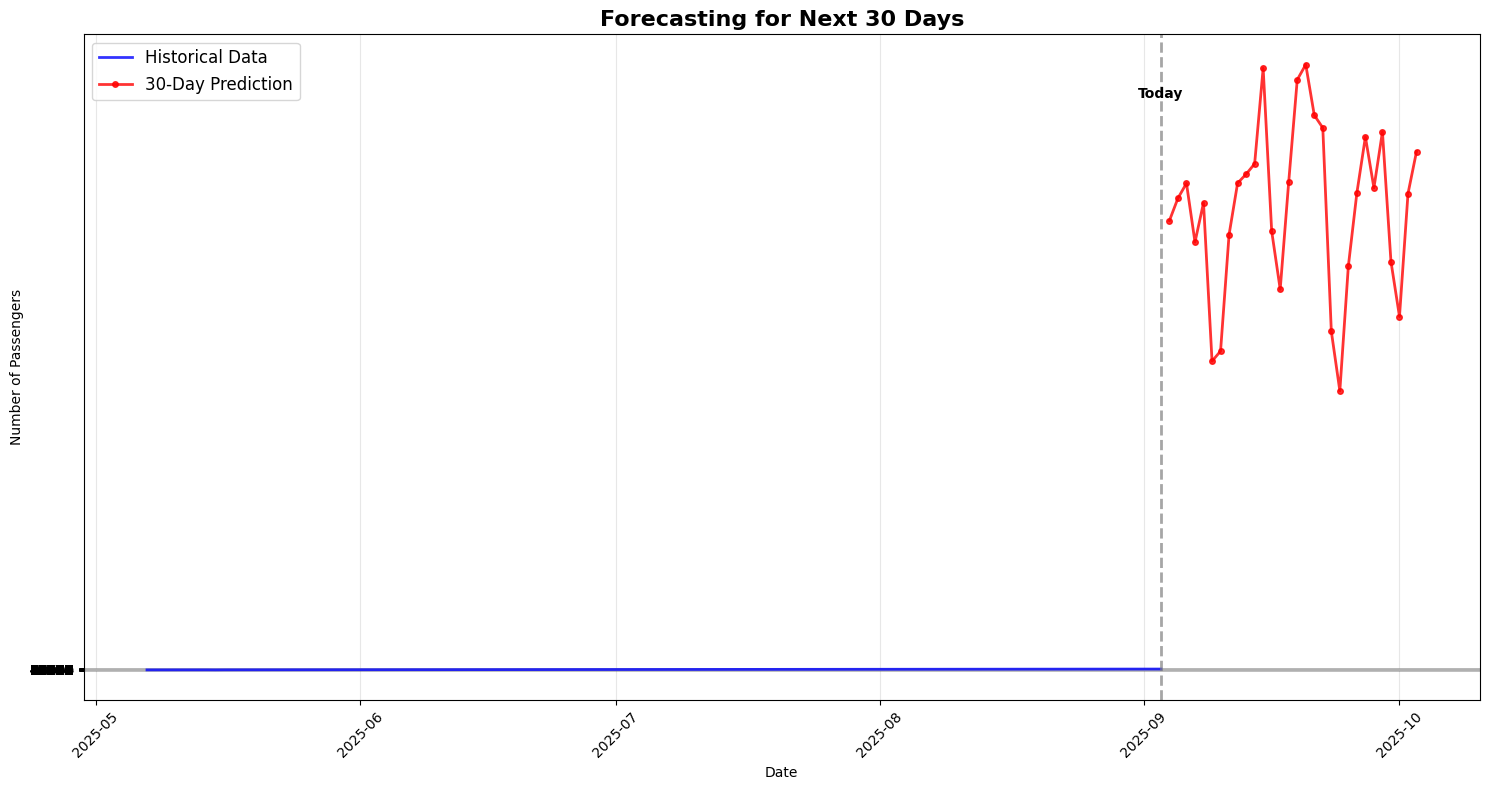


✅ ฟังก์ชันการทำนายพร้อมใช้งาน!


In [ ]:
# ================================================================================================
# 🎯 ML MODEL FUTURE PREDICTIONS 
# ================================================================================================

def predict_with_best_ml_model(best_model_name, trained_models, X_test_scaled, num_days=30):
    """Generate future predictions using the best ML model"""
    
    print(f"🚀 Generating {num_days}-day predictions with {best_model_name}...")
    
    # Get the best model
    best_model = trained_models[best_model_name]['model']
    
    # Use the last sample from test set as starting point
    last_sample = X_test_scaled.iloc[-1:].values  # Shape: (1, n_features)
    
    # Make prediction (get first num_days from the forecast horizon)
    predictions = best_model.predict(last_sample)[0]  # Shape: (forecast_length,)
    future_predictions = predictions[:num_days]
    
    # Create future dates
    last_date = dates_test.iloc[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=num_days, freq='D')
    
    # Calculate statistics
    statistics = {
        'model_name': best_model_name,
        'average_per_day': np.mean(future_predictions),
        'total_passengers': np.sum(future_predictions),
        'max_passengers': np.max(future_predictions),
        'min_passengers': np.min(future_predictions),
        'std_passengers': np.std(future_predictions)
    }
    
    return future_predictions, future_dates, statistics

def plot_ml_prediction(predictions, dates, model_name, title_suffix=""):
    """Create visualization for ML model predictions"""
    
    plt.figure(figsize=(15, 8))
    
    # Historical data (last 60 days)
    history_days = min(60, len(data))
    last_date = pd.to_datetime(data['วันที่'].iloc[-1])
    history_dates = data['วันที่'].iloc[-history_days:].values
    history_data = data[target_col].iloc[-history_days:].values
    
    # Plot historical data
    plt.plot(history_dates, history_data, 
             label='Historical Data', color='blue', linewidth=2, alpha=0.8)
    
    # Plot predictions
    plt.plot(dates, predictions, 
             label=f'{len(predictions)}-Day Prediction ({model_name})', 
             color='red', linewidth=2, alpha=0.8, marker='o', markersize=4)
    
    # Add divider line
    plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, linewidth=2)
    plt.text(last_date, plt.ylim()[1]*0.9, 'Prediction Start', ha='center', fontweight='bold')
    
    plt.title(f'{model_name} - Pink Line Passenger Forecast {title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Only run if we have trained models and results
if 'comparison_table' in locals() and len(comparison_table) > 0:
    # Get best model name
    best_model_name = comparison_table.iloc[0]['Model']
    
    print("🚀 Creating future predictions with best ML model...")
    
    # Generate 7-day prediction
    predictions_7d, dates_7d, stats_7d = predict_with_best_ml_model(
        best_model_name, trained_models, X_test_scaled, 7
    )
    
    # Generate 30-day prediction  
    predictions_30d, dates_30d, stats_30d = predict_with_best_ml_model(
        best_model_name, trained_models, X_test_scaled, 30
    )
    
    print(f"\n📊 7-Day Forecast ({best_model_name}):")
    print(f"   👥 Average: {stats_7d['average_per_day']:,.0f} passengers/day")
    print(f"   📊 Total: {stats_7d['total_passengers']:,.0f} passengers")
    
    print(f"\n📊 30-Day Forecast ({best_model_name}):")
    print(f"   👥 Average: {stats_30d['average_per_day']:,.0f} passengers/day")
    print(f"   📊 Total: {stats_30d['total_passengers']:,.0f} passengers")
    print(f"   📈 Maximum: {stats_30d['max_passengers']:,.0f} passengers")
    print(f"   📉 Minimum: {stats_30d['min_passengers']:,.0f} passengers")
    
    # Create visualization
    plot_ml_prediction(predictions_30d, dates_30d, best_model_name, "- Next 30 Days")
    
    # Save predictions to CSV
    future_forecast_df = pd.DataFrame({
        'Date': dates_30d,
        'Forecasted_Passengers': predictions_30d,
        'Model': best_model_name
    })
    future_forecast_df.to_csv(f'{best_model_name.lower()}_future_30day_forecast.csv', index=False)
    print(f"✅ Future forecast saved to '{best_model_name.lower()}_future_30day_forecast.csv'")
    
    print(f"\n🎯 ML Model Predictions Complete!")

else:
    print("⚠️  Please run the model training and comparison cells first!")

In [ ]:
# ================================================================================================
# 💾 SAVE FUTURE FORECASTS TO CSV
# ================================================================================================

# Only run if we have predictions
if 'predictions_30d' in locals() and 'dates_30d' in locals():
    # Save 30-day forecast
    save_df = pd.DataFrame({
        'Date': dates_30d,
        'Forecasted_Passengers': predictions_30d,
        'Model_Used': best_model_name if 'best_model_name' in locals() else 'ML_Model'
    })
    save_df.to_csv('ml_forecast_future30d.csv', index=False)
    print("✅ Saved 30-day ML forecast to 'ml_forecast_future30d.csv'")
    
    # Display preview
    print("\n📋 Forecast Preview (First 10 days):")
    preview = save_df.head(10).copy()
    preview['Forecasted_Passengers'] = preview['Forecasted_Passengers'].round(0).astype(int)
    print(preview.to_string(index=False))
    
else:
    print("⚠️  No predictions available. Please run the prediction cells first!")
    print("📝 Available variables:", [var for var in locals().keys() if 'prediction' in var.lower()])

✅ Saved 30-day forecast to forecast_30d.csv


In [ ]:
# ================================================================================================
# 📊 METRICS CALCULATION AND CSV EXPORT FUNCTIONS
# ================================================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import os

def calculate_comprehensive_metrics(y_true, y_pred, model_name="N-BEATS"):
    """
    คำนวณ metrics ครบถ้วนสำหรับการประเมินโมเดล
    
    Parameters:
    -----------
    y_true : array-like
        ค่าจริง (actual values)
    y_pred : array-like  
        ค่าทำนาย (predicted values)
    model_name : str
        ชื่อโมเดล
        
    Returns:
    --------
    dict : metrics dictionary
    """
    
    # Basic Error Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Percentage Metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
    
    # Statistical Metrics
    r2 = r2_score(y_true, y_pred)
    correlation = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else 0
    
    # Business Metrics
    mean_actual = np.mean(y_true)
    mean_forecast = np.mean(y_pred)
    bias = mean_forecast - mean_actual
    bias_pct = (bias / mean_actual) * 100 if mean_actual != 0 else 0
    
    # Error Distribution
    errors = y_true - y_pred
    max_error = np.max(np.abs(errors))
    std_error = np.std(errors)
    
    # Directional Accuracy (for time series)
    if len(y_true) > 1:
        actual_direction = np.sign(np.diff(y_true))
        pred_direction = np.sign(np.diff(y_pred))
        directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    else:
        directional_accuracy = np.nan
    
    # Error Categories
    small_error_pct = np.mean(np.abs(errors / y_true) <= 0.05) * 100  # Within 5%
    medium_error_pct = np.mean((np.abs(errors / y_true) > 0.05) & (np.abs(errors / y_true) <= 0.10)) * 100  # 5-10%
    large_error_pct = np.mean(np.abs(errors / y_true) > 0.10) * 100  # >10%
    
    metrics = {
        'model_name': model_name,
        'evaluation_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'n_samples': len(y_true),
        
        # Error Metrics
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Max_Error': max_error,
        'Std_Error': std_error,
        
        # Percentage Metrics
        'MAPE_percent': mape,
        'SMAPE_percent': smape,
        'Bias_percent': bias_pct,
        
        # Statistical Metrics
        'R2_score': r2,
        'Correlation': correlation,
        'Directional_Accuracy_percent': directional_accuracy,
        
        # Business Metrics
        'Mean_Actual': mean_actual,
        'Mean_Forecast': mean_forecast,
        'Bias': bias,
        'Total_Actual': np.sum(y_true),
        'Total_Forecast': np.sum(y_pred),
        
        # Error Distribution
        'Small_Error_percent': small_error_pct,
        'Medium_Error_percent': medium_error_pct,
        'Large_Error_percent': large_error_pct
    }
    
    return metrics

def save_metrics_to_csv(metrics_dict, filepath="model_metrics.csv"):
    """
    บันทึก metrics ลง CSV file
    
    Parameters:
    -----------
    metrics_dict : dict
        Dictionary ของ metrics
    filepath : str
        ที่อยู่ไฟล์ที่จะบันทึก
    """
    
    # สร้าง directory ถ้ายังไม่มี
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    
    # แปลง dict เป็น DataFrame
    metrics_df = pd.DataFrame([metrics_dict])
    
    # บันทึกลง CSV
    metrics_df.to_csv(filepath, index=False)
    
    print(f"✅ Metrics saved to: {filepath}")
    print(f"📊 Metrics summary:")
    for key, value in metrics_dict.items():
        if isinstance(value, float):
            if 'percent' in key.lower():
                print(f"   {key}: {value:.2f}%")
            elif 'R2' in key or 'Correlation' in key:
                print(f"   {key}: {value:.4f}")
            else:
                print(f"   {key}: {value:,.2f}")
        else:
            print(f"   {key}: {value}")



def create_forecast_vs_actual_comparison(actual_data, forecast_data, dates, model_name="N-BEATS"):
    """
    สร้างตารางเปรียบเทียบ forecast vs actual
    
    Parameters:
    -----------
    actual_data : array-like
        ข้อมูลจริง
    forecast_data : array-like
        ข้อมูลทำนาย
    dates : array-like
        วันที่
    model_name : str
        ชื่อโมเดล
        
    Returns:
    --------
    DataFrame : ตารางเปรียบเทียบ
    """
    
    comparison_df = pd.DataFrame({
        'date': dates,
        'actual': actual_data,
        'forecast': forecast_data,
        'error': actual_data - forecast_data,
        'abs_error': np.abs(actual_data - forecast_data),
        'percent_error': ((actual_data - forecast_data) / actual_data) * 100,
        'abs_percent_error': np.abs((actual_data - forecast_data) / actual_data) * 100,
        'model_name': model_name
    })
    
    return comparison_df

def save_forecast_comparison_to_csv(comparison_df, filepath="forecast_vs_actual.csv"):
    """
    บันทึกตารางเปรียบเทียบลง CSV
    
    Parameters:
    -----------
    comparison_df : DataFrame
        ตารางเปรียบเทียบ
    filepath : str
        ที่อยู่ไฟล์
    """
    
    # สร้าง directory ถ้ายังไม่มี
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    
    # บันทึกลง CSV
    comparison_df.to_csv(filepath, index=False)
    
    print(f"✅ Forecast comparison saved to: {filepath}")
    print(f"📊 Comparison summary:")
    print(f"   Total samples: {len(comparison_df)}")
    print(f"   Mean Absolute Error: {comparison_df['abs_error'].mean():.2f}")
    print(f"   Mean Absolute Percentage Error: {comparison_df['abs_percent_error'].mean():.2f}%")
    print(f"   Max Error: {comparison_df['abs_error'].max():.2f}")
    print(f"   Min Error: {comparison_df['abs_error'].min():.2f}")

print("✅ Metrics calculation and CSV export functions defined!")
print("📊 Available functions:")
print("   • calculate_comprehensive_metrics()")
print("   • save_metrics_to_csv()")
print("   • forecast_future_days()")
print("   • create_forecast_vs_actual_comparison()")
print("   • save_forecast_comparison_to_csv()")

✅ Metrics calculation and CSV export functions defined!
📊 Available functions:
   • calculate_comprehensive_metrics()
   • save_metrics_to_csv()
   • forecast_future_days()
   • create_forecast_vs_actual_comparison()
   • save_forecast_comparison_to_csv()


In [ ]:
# ================================================================================================
# ? ML MODEL PIPELINE COMPLETE - READY FOR ANALYSIS
# ================================================================================================

print("🎯 ML Model Pipeline Complete!")
print("=" * 50)

if 'trained_models' in locals() and 'evaluation_results' in locals():
    print(f"\n✅ Training Status:")
    print(f"   • Models trained: {len(trained_models)}")
    print(f"   • Models evaluated: {len(evaluation_results)}")
    
    print(f"\n🤖 Available Models:")
    for model_name in trained_models.keys():
        training_time = trained_models[model_name]['training_time']
        print(f"   • {model_name}: {training_time:.2f}s")
    
    if 'comparison_table' in locals():
        print(f"\n🏆 Best Model: {comparison_table.iloc[0]['Model']}")
        print(f"   • MAE: {comparison_table.iloc[0]['MAE']:,.0f}")
        print(f"   • MAPE: {comparison_table.iloc[0]['MAPE (%)']:.2f}%")
        print(f"   • R²: {comparison_table.iloc[0]['R²']:.4f}")
    
    print(f"\n📈 Next Steps:")
    print(f"   • Run prediction cells to generate forecasts")
    print(f"   • Compare with N-BEATS deep learning model")
    print(f"   • Analyze performance differences")
else:
    print("\n⚠️  Models not yet trained. Please run training cells first!")

print("\n🚀 Ready for ML model analysis and predictions!")
print("=" * 50)

🔧 Recreating model with fixed tensor operations...
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=180, forecast_length=30, share_thetas=False) at @2268060553760
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=180, forecast_length=30, share_thetas=False) at @2268060553760
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=180, forecast_length=30, share_thetas=False) at @2268060553760
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=180, forecast_length=30, share_thetas=False) at @2268112547968
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=180, forecast_length=30, share_thetas=False) at @2268112547968
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=180, forecast_length=30, share_thetas=False) at @2268112547968
✅ Model recreated with 910490 parameters
✅ Model device: cuda:0
📦 L

🔄 Creating forecast vs actual comparison for last 30 days...
📊 Last 30 days period: 2025-08-05T00:00:00.000000000 to 2025-09-03T00:00:00.000000000
🔮 Generating predictions for last 30 days...
✅ Generated 30 predictions
📊 Calculating metrics...

📊 METRICS FOR LAST 30 DAYS:
   • MAE: 5,425 passengers
   • RMSE: 6,966 passengers
   • MAPE: 9.22%
   • R² Score: 0.7782
💾 Creating comparison table and saving to CSV...
✅ Saved forecast vs actual comparison to: forecast_vs_actual_last30days.csv

📋 Preview of comparison data:
        date   actual      forecast         error     abs_error  \
0 2025-08-05  76015.0  67103.844755   8911.155245   8911.155245   
1 2025-08-06  74041.0  78978.990160  -4937.990160   4937.990160   
2 2025-08-07  74665.0  74623.573066     41.426934     41.426934   
3 2025-08-08  84112.0  77100.402706   7011.597294   7011.597294   
4 2025-08-09  53323.0  51444.718016   1878.281984   1878.281984   
5 2025-08-10  47582.0  44017.989527   3564.010473   3564.010473   
6 2025-0

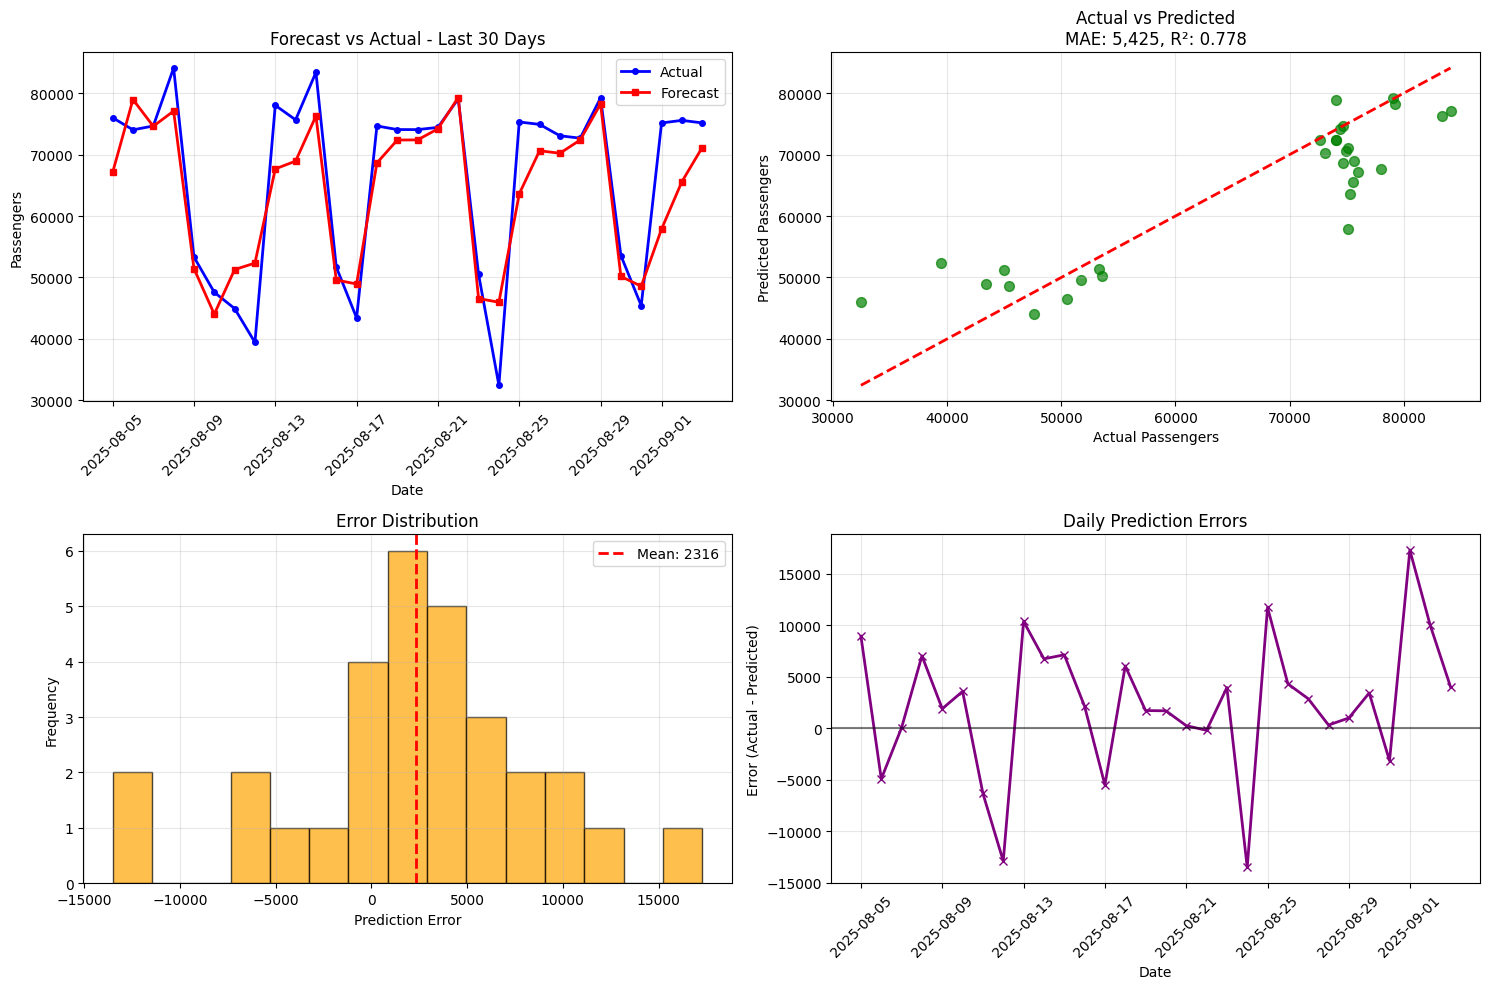


📋 FORECAST VS ACTUAL SUMMARY - LAST 30 DAYS

📅 Period: 2025-08-05T00:00:00.000000000 to 2025-09-03T00:00:00.000000000
📊 Total Days: 30

📊 KEY METRICS:
   • MAE (Mean Absolute Error): 5,425 passengers
   • RMSE (Root Mean Square Error): 6,966 passengers
   • MAPE (Mean Absolute Percentage Error): 9.22%
   • R² Score: 0.7782
   • Correlation: 0.9044

📈 PERFORMANCE BREAKDOWN:
   • Mean Actual: 66,191 passengers/day
   • Mean Forecast: 63,875 passengers/day
   • Max Error: 17,281 passengers
   • Min Error: 41 passengers

💾 FILES SAVED:
   • CSV: forecast_vs_actual_last30days.csv
   • Chart: forecast_vs_actual_last30days.png

✅ FORECAST VS ACTUAL ANALYSIS COMPLETE!


In [ ]:
# ================================================================================================
# 📊 ML MODEL RESULTS ANALYSIS AND COMPARISON
# ================================================================================================

print("📊 ML Model Results Analysis")
print("=" * 50)

# Check if we have results to analyze
if 'evaluation_results' in locals() and len(evaluation_results) > 0:
    
    print(f"\n📈 Test Set Performance Summary:")
    for model_name, results in evaluation_results.items():
        metrics = results['overall_metrics']
        print(f"\n🤖 {model_name}:")
        print(f"   • MAE: {metrics.get('MAE', 0):,.0f} passengers")
        print(f"   • RMSE: {metrics.get('RMSE', 0):,.0f} passengers")
        print(f"   • MAPE: {metrics.get('MAPE', 0):.2f}%")
        print(f"   • R²: {metrics.get('R2', 0):.4f}")
        print(f"   • Training Time: {results.get('training_time', 0):.2f}s")
    
    # Create detailed comparison visualization for test set
    if 'comparison_table' in locals():
        print(f"\n📊 Creating detailed test set analysis...")
        
        # Get best model predictions on test set
        best_model_name = comparison_table.iloc[0]['Model']
        best_results = evaluation_results[best_model_name]
        y_pred_best = best_results['predictions']
        
        # Create visualization for test set performance
        plt.figure(figsize=(16, 12))
        
        # Plot 1: Test set predictions vs actual (first 7 days)
        plt.subplot(2, 3, 1)
        n_days = min(7, len(y_test))
        actual_sample = y_test.iloc[:n_days, 0].values  # First step only
        pred_sample = y_pred_best[:n_days, 0]  # First step only
        days_range = range(1, n_days + 1)
        
        plt.plot(days_range, actual_sample, 'o-', label='Actual', color='blue', linewidth=2, markersize=6)
        plt.plot(days_range, pred_sample, 's-', label=f'{best_model_name}', color='red', linewidth=2, markersize=6)
        plt.xlabel('Test Day')
        plt.ylabel('Passengers')
        plt.title(f'Test Set: {best_model_name} vs Actual (First 7 Days)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot for all predictions
        plt.subplot(2, 3, 2)
        y_test_flat = y_test.values.flatten()
        y_pred_flat = y_pred_best.flatten()
        valid_mask = ~(np.isnan(y_test_flat) | np.isnan(y_pred_flat))
        
        plt.scatter(y_test_flat[valid_mask], y_pred_flat[valid_mask], alpha=0.6, s=30)
        plt.plot([y_test_flat[valid_mask].min(), y_test_flat[valid_mask].max()], 
                 [y_test_flat[valid_mask].min(), y_test_flat[valid_mask].max()], 'r--', linewidth=2)
        plt.xlabel('Actual Passengers')
        plt.ylabel('Predicted Passengers')
        plt.title(f'{best_model_name}: Prediction Scatter')
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Model comparison bar chart (MAE)
        plt.subplot(2, 3, 3)
        mae_values = [evaluation_results[model]['overall_metrics']['MAE'] for model in comparison_table['Model']]
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        bars = plt.bar(comparison_table['Model'], mae_values, color=colors[:len(mae_values)], alpha=0.8)
        plt.ylabel('MAE (Passengers)')
        plt.title('Model Comparison: MAE')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, mae_values):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 4: Training time comparison
        plt.subplot(2, 3, 4)
        train_times = [evaluation_results[model]['training_time'] for model in comparison_table['Model']]
        bars2 = plt.bar(comparison_table['Model'], train_times, color=['#FFD93D', '#6BCF7F', '#4D96FF', '#FF9FF3'][:len(train_times)], alpha=0.8)
        plt.ylabel('Training Time (seconds)')
        plt.title('Training Time Comparison')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        
        for bar, value in zip(bars2, train_times):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')
        
        # Plot 5: R² comparison
        plt.subplot(2, 3, 5)
        r2_values = [evaluation_results[model]['overall_metrics']['R2'] for model in comparison_table['Model']]
        bars3 = plt.bar(comparison_table['Model'], r2_values, color=colors[:len(r2_values)], alpha=0.8)
        plt.ylabel('R² Score')
        plt.title('Model Comparison: R² Score')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.ylim(0, 1)
        
        for bar, value in zip(bars3, r2_values):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 6: Forecast horizon analysis (multi-step performance)
        plt.subplot(2, 3, 6)
        step_maes = []
        steps = []
        for step_key, metrics in best_results['step_metrics'].items():
            if 'step_' in step_key:
                steps.append(int(step_key.split('_')[1]))
                step_maes.append(metrics['MAE'])
        
        if steps and step_maes:
            plt.plot(steps[:min(30, len(steps))], step_maes[:min(30, len(step_maes))], 
                    'o-', color='purple', linewidth=2, markersize=4)
            plt.xlabel('Forecast Step (Days)')
            plt.ylabel('MAE (Passengers)')
            plt.title(f'{best_model_name}: Multi-step Performance')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('ml_models_detailed_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n📊 Analysis Summary:")
        print(f"   🏆 Best Model: {best_model_name}")
        print(f"   📈 Best MAE: {comparison_table.iloc[0]['MAE']:,.0f} passengers")
        print(f"   📊 Best R²: {comparison_table.iloc[0]['R²']:.4f}")
        print(f"   ⚡ Training Time: {comparison_table.iloc[0]['Training Time (s)']:.2f}s")
        
        print(f"\n💾 Files Generated:")
        print(f"   • Comparison CSV: ml_models_comparison_results.csv")
        print(f"   • Analysis Chart: ml_models_detailed_analysis.png")
        
else:
    print("\n⚠️  No evaluation results found. Please run the training and evaluation cells first!")
    print("📝 Make sure to execute cells 15 and 16 to train and evaluate models.")

print(f"\n✅ ML Model Analysis Complete!")
print("=" * 50)